In [1]:
# %reload_ext snakeviz
%matplotlib inline
%run SBRG.py
import matplotlib.pyplot as plt

Required package: 
- Numpy, 
- Numba (to accelerate entropy calculation), 
- Qutip (easy to compare with ED results)

# Core
## Pauli Algebra
Pauli matrix class. A Pauli matrix is denoted as
$$\sigma=\mathrm{i}^{x\cdot z}\prod_{i\in Xs}X_i\prod_{i\in Zs}Z_i=\mathrm{i}^{x\cdot z}\prod_{i}X_i^{x_i}Z_i^{z_i},$$
where $x_i=\delta(i\in Xs)$, $z_i=\delta(i\in Zs)$ are vectors of 0,1, and $X_i$, $Z_i$ are the Pauli matrix on site $i$.

Pauli matrices can be created by `mkMat`
- from Xs, Zs sets: `mkMat(Xs, Zs)`,
- or from dict of indices: `mkMat({i:mu, ...})`,
- or from list of indices: `mkMat([m0, mu1, ...])`.

In [2]:
[mkMat({0,1},{1,2}), mkMat({0:1,1:2,2:3}), mkMat([1,2,3])]

[<Xs:[0, 1] Zs:[1, 2]>, <Xs:[0, 1] Zs:[1, 2]>, <Xs:[0, 1] Zs:[1, 2]>]

`Mat` is hashable and can be compared.

In [3]:
print(hash(mkMat()))
mkMat() == mkMat([])

4553746914421323778


True

The commutativity of two Pauli operators can be checked by `is_commute`

In [4]:
is_commute(mkMat([0,1,0]),mkMat([1,2,3]))

False

Merge two Pauli operators by indices. Coefficients are not calculated here. The coefficient can be restored from the commutation relations later.

In [5]:
pdot(mkMat([0,1,0]),mkMat([1,2,3]))

<Xs:[0] Zs:[1, 2]>

### Pauli Monomial
A term of Pauli operator `Term.mat` with a constant multiple `Term.val`.

In [6]:
[Term(), Term(mkMat([1,2])),Term(mkMat([1,2]),-3.2)]

[1.0 <Xs:[] Zs:[]>, 1.0 <Xs:[0, 1] Zs:[1]>, -3.2 <Xs:[0, 1] Zs:[1]>]

Consider $\sigma_A=\mathrm{i}^{x_A\cdot z_A} X_A Z_A$, $\sigma_B=\mathrm{i}^{x_B\cdot z_B} X_B Z_B$, then the product reads:
$$\sigma_A\sigma_B=\mathrm{i}^{x_A\cdot z_A+x_B\cdot z_B+2 z_A\cdot x_B}\quad (X_A X_B) (Z_A Z_B)=\mathrm{i}^{x_A\cdot z_A+x_B\cdot z_B-x_C\cdot z_C+2 z_A\cdot x_B}\quad \mathrm{i}^{x_C\cdot z_C}X_C Z_C=\mathrm{i}^{n^{C}_{AB}}\; \sigma_C,$$
where $X_C=X_AX_B$, $Z_C=Z_AZ_B$ and $z_C = (z_A+z_B)\mod 2$. The power of $\mathrm{i}$ is
$$n^{C}_{AB}=x_A\cdot z_A+x_B\cdot z_B-x_C\cdot z_C+2 z_A\cdot x_B$$

In [7]:
dot(Term(mkMat([1,2])),Term(mkMat([3,3])))

1.0 <Xs:[0, 1] Zs:[0]>

In [8]:
idot(Term(mkMat([2,0])),Term(mkMat([3,3])))

-1.0 <Xs:[0] Zs:[1]>

## Hamiltonian
Hamiltonian `Ham` is a sum of Pauli monomial terms. It can be created from a list of terms.

In [9]:
H = Ham(
    [Term(mkMat([0,1,1]),0.5),
     Term(mkMat([3,0,0]),0.2),
     Term(mkMat([0,3,3]),0.8),
     Term(mkMat([1,3,0]),1.0)])
H

[1.0 <Xs:[0] Zs:[1]>, 0.8 <Xs:[] Zs:[1, 2]>, 0.5 <Xs:[1, 2] Zs:[]>, 0.2 <Xs:[] Zs:[0]>]

For our purpose, we generate Clifford algebra by $C_4$ rotation $R_{C4}$, like $\pi/4$ phase gate
$$R_{C4}(\sigma^{[\mu]})=\exp\left(i\dfrac{\pi}{4}\sigma^{[\mu]}\right)=\dfrac{1}{\sqrt{2}}(1+i \sigma^{[\mu]})$$

Its adjoint on matrix $\sigma^{[\nu]}$ is given by
$$R_{C4}^{\dagger}(\sigma^{[\mu]})\sigma^{[\nu]}R_{C4}(\sigma^{[\mu]})=i\sigma^{[\nu]}\sigma^{[\mu]},~\text{if they anti-commute}; \sigma^{[\nu]},~\text{otherwise}$$

We can use SBRG to calculate C4 rotation on a Hamiltonian

In [10]:
H = Ham(
    [Term(mkMat([0,1]),0.5),
     Term(mkMat([3,0]),0.2)])
print('Hamiltonian: ', H)

Hamiltonian:  [0.5 <Xs:[1] Zs:[]>, 0.2 <Xs:[] Zs:[0]>]


In [11]:
H.C4(Term(mkMat([0,2])))

In [12]:
print('Hamiltonian after rotation:', H)

Hamiltonian after rotation: [-0.5 <Xs:[] Zs:[1]>, 0.2 <Xs:[] Zs:[0]>]


We can also use a list to contain a serial of $R_{C4}$ rotations, and use ".forward()" function to rotate Hamiltonain sequentially.

In [13]:
H = Ham(
    [Term(mkMat([0,1]),0.5),
     Term(mkMat([3,0]),0.2)])
print('Hamiltonian: ', H)
C4_list = [Term(mkMat([0,2])),Term(mkMat([2,0]))]
H.forward(C4_list)
print('Hamiltonian after rotation: ', H)

Hamiltonian:  [0.5 <Xs:[1] Zs:[]>, 0.2 <Xs:[] Zs:[0]>]
Hamiltonian after rotation:  [-0.5 <Xs:[] Zs:[1]>, 0.2 <Xs:[0] Zs:[]>]


### Create your own physical model of disorder systems

A model will be contained in the `Model()` class. Here we will demostrate how to create your own model with `SBRG`.

Here, we demostrate how to create the random transverse field Ising model with periodic boundary condition using `Model` class:
$$H=-\sum_{i}J_i X_i X_{i+1}-\sum_{i}K_i Z_i Z_{i+1}-\sum_i h_i Z_i$$

In [14]:
# quantum Ising model
def Custom_TFIsing(L, **para):
    # L - number of sites (assuming PBC)
    # model - a dict of model parameters
    try: # set parameter alpha
        alpha = para['alpha']
        alpha_J = alpha
        alpha_K = alpha
        alpha_h = alpha
    except:
        alpha_J = para.get('alpha_J',1)
        alpha_K = para.get('alpha_K',1)
        alpha_h = para.get('alpha_h',1)
    model = Model()
    model.size = L
    H_append = model.terms.append
    rnd_beta = random.betavariate
    for i in range(L):
        H_append(Term(mkMat({i: 1, (i+1)%L: 1}), -para['J']*rnd_beta(alpha_J, 1)))
        H_append(Term(mkMat({i: 3, (i+1)%L: 3}), -para['K']*rnd_beta(alpha_K, 1)))
        H_append(Term(mkMat({i: 3}), -para['h']*rnd_beta(alpha_h, 1)))
    model.terms = [term for term in model.terms if abs(term.val) > 0]
    return model

Now we can use it to generate random Hamiltonians for transverse field Ising model!

In [15]:
H = Custom_TFIsing(10,**{'alpha':1, 'J':0, 'K':1, 'h':0.1})

We can print the terms in our model:

In [16]:
H.terms

[-0.26216536595768364 <Xs:[] Zs:[0, 1]>,
 -0.07331409782510911 <Xs:[] Zs:[0]>,
 -0.18135000614695782 <Xs:[] Zs:[1, 2]>,
 -0.014367642901688682 <Xs:[] Zs:[1]>,
 -0.09833526238207803 <Xs:[] Zs:[2, 3]>,
 -0.07933741095985097 <Xs:[] Zs:[2]>,
 -0.43706198604889657 <Xs:[] Zs:[3, 4]>,
 -0.07406712375788908 <Xs:[] Zs:[3]>,
 -0.8154326125094679 <Xs:[] Zs:[4, 5]>,
 -0.06965527185793578 <Xs:[] Zs:[4]>,
 -0.6216271216182655 <Xs:[] Zs:[5, 6]>,
 -0.08992626014738053 <Xs:[] Zs:[5]>,
 -0.26501466488084463 <Xs:[] Zs:[6, 7]>,
 -0.027431248519053698 <Xs:[] Zs:[6]>,
 -0.8894988719555125 <Xs:[] Zs:[7, 8]>,
 -0.027112836809803705 <Xs:[] Zs:[7]>,
 -0.8037409572265031 <Xs:[] Zs:[8, 9]>,
 -0.09338510898093769 <Xs:[] Zs:[8]>,
 -0.9697326564031314 <Xs:[] Zs:[0, 9]>,
 -0.09740373603703097 <Xs:[] Zs:[9]>]

### Bridge to `Qutip` package

`Qutip` is an open source python package for quantum system simulation. 

And we have build the tool to transform SBRG `Ham` class object to `Qutip` Qobj class object.

To transform SBRG Hamiltonian to Qutip Hamiltonian, you can use `system_Ham_to_qutip_Ham(system_size, SBRG_Hamiltonian)`

Links to `Qutip` documents: [Link](http://nbviewer.ipython.org/urls/raw.github.com/jrjohansson/qutip-lectures/master/Lecture-0-Introduction-to-QuTiP.ipynb)

Suppose we create a `SBRG` Hamiltonian:

In [17]:
H = Ham(
    [Term(mkMat([0,1]),0.5),
     Term(mkMat([3,0]),0.2)])

We can transform it to `Qutip` Hamiltonian:

In [18]:
Qutip_H = system_Ham_to_qutip_Ham(2,H)
print(Qutip_H)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.2  0.5  0.   0. ]
 [ 0.5  0.2  0.   0. ]
 [ 0.   0.  -0.2  0.5]
 [ 0.   0.   0.5 -0.2]]


Let's try transverse field Ising model Hamiltonian:

In [19]:
H = Custom_TFIsing(10,**{'alpha':1, 'J':0, 'K':1, 'h':0.1})

In [20]:
Qutip_H = system_Ham_to_qutip_Ham(10, H)

In [21]:
print(Qutip_H)

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape = (1024, 1024), type = oper, isherm = True
Qobj data =
[[-5.46627366  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -3.78863957  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -3.76134386 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -3.0524237   0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -3.21479928
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -4.72627332]]


## SBRG

### How to use SBRG algorithm diagonalizing our Hamiltonian iteratively?

In [22]:
model = Custom_TFIsing(10,**{'alpha':1, 'J':1, 'K':0, 'h':0})
system = SBRG(model)

There are some hyperparameters that controls how many new terms generated by perturbation theory are going to be kept:

SBRG.tol      :: float : terms with energy < leading energy * tol will be truncated

SBRG.max_rate :: float : each RG step allows at most (max_rate * num of off-diagonal terms) amount of new terms

In [23]:
system.tol = 0.
system.max_rate = 1000.
system.run()

Now the Hamiltonian is fully diagonalized. We can check the effective Hamiltonian, and find it is all in pauli-Z basis.

In [24]:
system.Heff

[-0.8671575172034801 <Xs:[] Zs:[1]>,
 -0.8081486352315497 <Xs:[] Zs:[2]>,
 -0.7350048411695649 <Xs:[] Zs:[6]>,
 -0.6968006349114628 <Xs:[] Zs:[5]>,
 -0.6770677881016107 <Xs:[] Zs:[4]>,
 -0.5927071250829615 <Xs:[] Zs:[3]>,
 -0.23482245000371232 <Xs:[] Zs:[8]>,
 -0.22430549452076293 <Xs:[] Zs:[0]>,
 -0.003487516918250927 <Xs:[] Zs:[0, 1, 2, 3, 4, 5, 6, 7, 8]>,
 -0.03072720685950509 <Xs:[] Zs:[7]>]

We can find the ground state, and its associated energy by `.grndstate_blk()` function.

In [25]:
ground_state, energy = system.grndstate_blk()

In [26]:
print('ground state is indicated by the effective bulk spins:')
ground_state

ground state is indicated by the effective bulk spins:


[1, 1, 1, 1, 1, 1, 1, 1, 1, -1]

In [27]:
energy

-4.8702292100028615

Instead of just getting ground state, you can also get the full spectrum of your Hamiltonian

In [28]:
full_spectrum = get_full_spectrum(system)

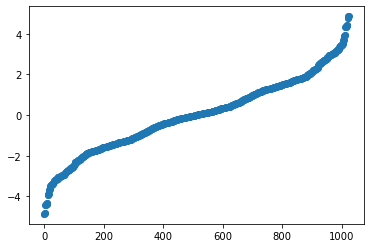

In [29]:
plt.plot(sorted(full_spectrum),'o')

## Expectation value of physical observables

Once we have diagonalize the Hamiltonian, we would also like to calculate some physical observables, such as magnitization, correlation, and etc. 

This can be done by calling `.measure_ops(self, ops, state)` for SBRG class object. It will calculate 
$$\langle \text{state}|\text{ops}|\text{state}\rangle$$

To calculate $\langle \text{state}|\text{ops}|\text{state}\rangle$ faster, SBRG will do all the calculation in the effective "bulk" spins space, where all the effective Hamiltonian is in the pauli-Z basis. Therefore, $|\text{state}\rangle$ will be specified in the pauli-Z effective basis. And we use a `list` to contain all the values for effective spins.

For example, suppose we have a 5 qubit system, one of the state could be $|\text{state}\rangle=[1,1,-1,-1,1]$. One should notice that this doesn't mean this state is a product state. This state may still be entangled in the original physical space, all the entanglement entropy is captured in the SBRG circuits, they "disentangle" the state to make calculation easier. We will cover entanglement entropy in the next section.

In [57]:
def spin_spin_cor(x, y):
    return Ham([Term(mkMat({x: 3, y: 3}), 1)])

def magnetization(x):
    return Ham([Term(mkMat({x: 3}), 1)])

In [ ]:
n_runs = 100
corr_array = np.zeros(100)
mag_array = np.zeros(shape=(5, 100))

K_array = np.array([0.6, 0.8, 1.0, 1.2, 1.4])

for i, K in enumerate(K_array):
    for run in range(n_runs):
        model = Custom_TFIsing(100,**{'alpha':1, 'J':1., 'K':K, 'h':0.1})
        system = SBRG(model)

        system.tol = 0.
        system.max_rate = 1000.
        system.run()

        ground_state, energy = system.grndstate_blk()

        for site in range(100):
            spin_01 = spin_spin_cor(0,site)
            mag_site = magnetization(site)
            corr_array[site] += system.measure_ops(spin_01, ground_state)
            mag_array[i, site] += system.measure_ops(mag_site, ground_state)

120
91
66
136
66
276
496
1176
66
210
820
300
4278
6555
780
10878
66
9591
406
1326
1326
820
17205
91806
203841
903
1567335
84255
66
18915
46056
1378
37950
1431
15753
138075
322003
167331
2534626
238395
the sum of the absolute values of trash is  0.011127761040802304
the max_len is 3455 and the total num is 238395
3815703
5552778
the sum of the absolute values of trash is  0.34274576313397037
the max_len is 5000 and the total num is 5552778
5221296
889111
the sum of the absolute values of trash is  0.8436150102956099
the max_len is 5000 and the total num is 889111
91
325
741
66
276
253
820
210
66
2628
325
861
17020
861
6786
5886
16110
21528
210
174936
8646
2080
8385
34980
528
354903
203203
1090026
6221628
47278
4560
81810
the sum of the absolute values of trash is  0.014174232144783186
the max_len is 2025 and the total num is 81810
1062153
9180
the sum of the absolute values of trash is  0.018639550849032988
the max_len is 680 and the total num is 9180
47278
419070
996166
the sum of the 

In [56]:
from scipy.optimize import curve_fit

def stretched_exp(r, A, psi):
    return np.exp(-A*r**psi)


corr_array[0] = n_runs
x_data = np.arange(100)
y_data = corr_array/n_runs

popt, pcov = curve_fit(stretched_exp, x_data[:50], y_data[:50])

pcov

array([[ 0.00160055, -0.00088412],
       [-0.00088412,  0.00074598]])

(0.0, 40.0)

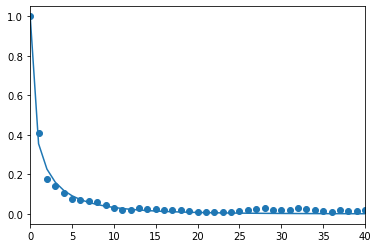

In [55]:

plt.scatter(x_data, y_data)
plt.plot(x_data, power_law(x_data, *popt))
plt.xlim(0, 40)

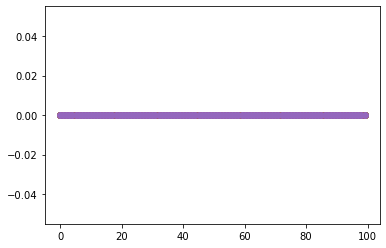

In [66]:
for i, K in enumerate(K_array):
    plt.scatter(x_data, mag_array[i,:]/n_runs)

## Entanglement Entropy

In [33]:
set()

set()